In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Constants
IMG_SIZE = 224
INPUT_DIR = "/kaggle/input/aptos2019-blindness-detection/train_images"

# Load labels
labels = pd.read_csv("/kaggle/input/aptos2019-blindness-detection/train.csv")
labels.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


### Visualize Images

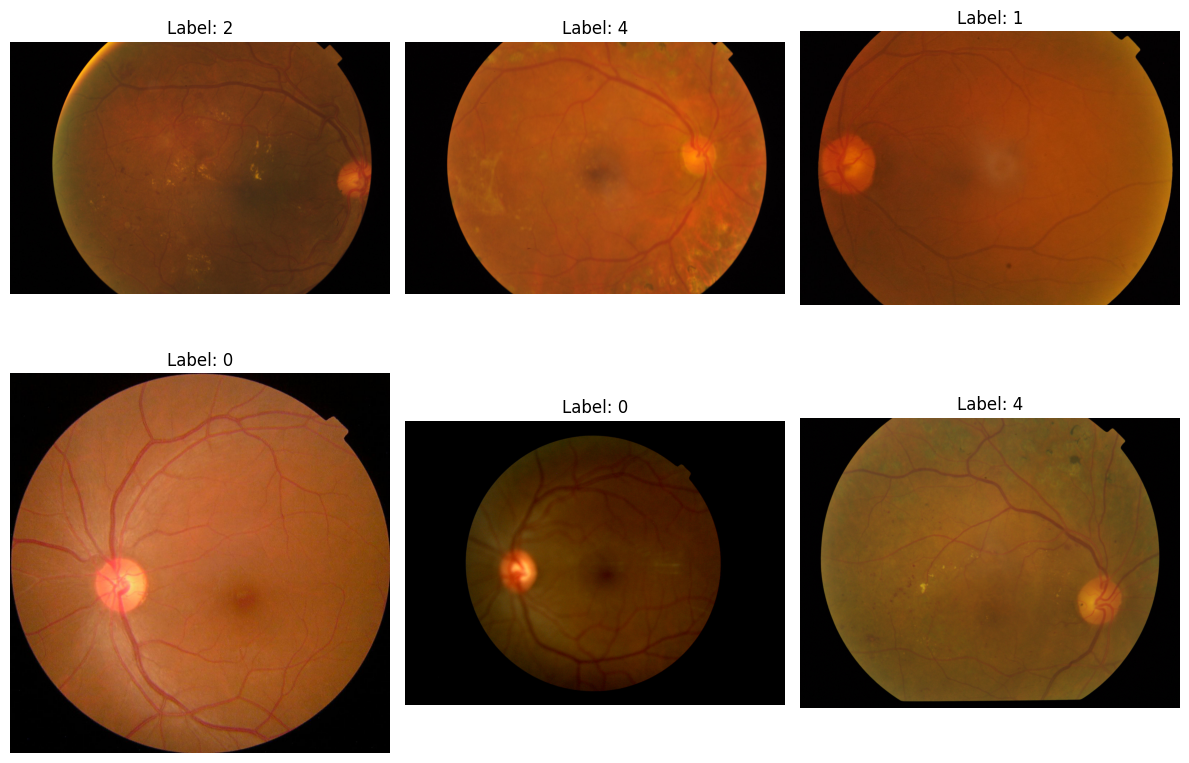

In [3]:
def show_raw_images(labels, img_dir, n=9):
    plt.figure(figsize=(12, 12))
    for i in range(n):
        img_id = labels.iloc[i]['id_code']
        label = labels.iloc[i]['diagnosis']
        img_path = os.path.join(img_dir, f"{img_id}.png")
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.title(f"Label: {label}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()


show_raw_images(labels, INPUT_DIR, n=6)

## Data Preprocessing

1. Resizing all images to 224 x 224
2. Normalizing pixel values to [0, 1]
3. Remove all the background
4. Apply CLAHE filters as well.

In [4]:
def preprocess_image(img_path, img_size = IMG_SIZE):
    img = cv2.imread(img_path)
    if img is None:
        return None

    #Remove black borders
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 15, 225, cv2.THRESH_BINARY)
    coords = cv2.findNonZero(thresh)
    if coords is not None:
        x, y, w, h = cv2.boundingRect(coords)
        img = img[y:y+h, x:x+w]

    #Resize image
    img = cv2.resize(img, (img_size, img_size))

    #Apply CLAHE to each channel
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a , b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit = 2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

    #Apply Gaussian Blur(denoise without removing key structures)
    img = cv2.GaussianBlur(img, (3, 3), 0)

    #Normalizing to [0,1]
    img = img.astype(np.float32) / 255.0

    return img

In [5]:
preprocessed_images = []
preprocessed_labels = []

for i in tqdm(range(len(labels))):
    img_id = labels.iloc[i]['id_code']
    label = labels.iloc[i]['diagnosis']
    img_path = os.path.join(INPUT_DIR, f"{img_id}.png")

    img = preprocess_image(img_path)

    if img is not None:
        preprocessed_images.append(img)
        preprocessed_labels.append(label)


# for i in tqdm(range(90)):
#     img_id = labels.iloc[i]['id_code']
#     label = labels.iloc[i]['diagnosis']
#     img_path = os.path.join(INPUT_DIR, f"{img_id}.png")

#     img = preprocess_image(img_path)

#     if img is not None:
#         preprocessed_images.append(img)
#         preprocessed_labels.append(label)

100%|██████████| 3662/3662 [10:02<00:00,  6.08it/s]


In [6]:
#Convert them to numpy arrays for model training
X = np.array(preprocessed_images)
y = np.array(preprocessed_labels)

print(f"Preprocessed {len(X)} images")
print(f"Shape of image: {X.shape}")

Preprocessed 3662 images
Shape of image: (3662, 224, 224, 3)


## Use 20 sample(balanced) for debugging(uncomment)

In [7]:
# # New lists for balanced subset
# X_subset = []
# y_subset = []

# for class_label in range(5):  # Classes 0 to 4
#     class_indices = np.where(y == class_label)[0]
#     selected_idx = np.random.choice(class_indices, 5, replace=False)

#     X_subset.extend(X[selected_idx])
#     y_subset.extend(y[selected_idx])

# X = np.array(X_subset)
# y = np.array(y_subset)

# print(f"Subset shape: {X.shape}, Labels: {y.shape}")

## Visualize preprocessed results

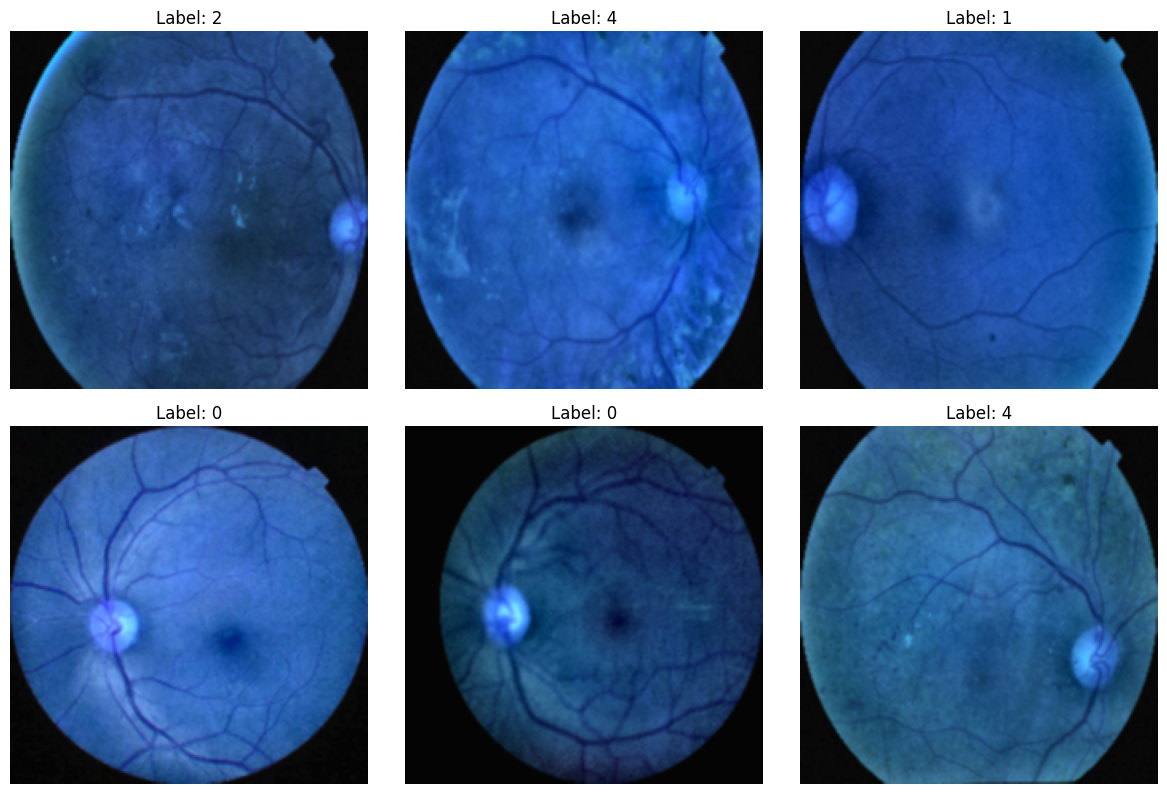

In [8]:
import matplotlib.pyplot as plt

def show_preprocessed_images(images, labels, n=9):
    plt.figure(figsize=(12, 12))
    for i in range(n):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_preprocessed_images(X, y, n=6)

## Prepare the processed data for the model

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [10]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import numpy as np
import torchvision.transforms.functional as F
from torchvision.transforms.functional import to_pil_image

class DRDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]  # (H, W, C), float32, in [0, 1]
        label = self.labels[idx]

        # Convert to torch tensor and transpose
        image = torch.tensor(image).permute(2, 0, 1).float()  # (C, H, W)

        # Convert to PIL image if using PIL-based transforms
        if self.transform:
            image = to_pil_image(image)        
            image = self.transform(image)      
            image = T.ToTensor()(image)     

        label = torch.tensor(label).long()
        return image, label

In [11]:
train_transforms = T.Compose([
    T.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),  # mild denoising
])

In [12]:
from torch.utils.data import WeightedRandomSampler

# Create datasets
train_dataset = DRDataset(X_train, y_train, train_transforms)
val_dataset = DRDataset(X_val, y_val)

# Step 1: Count frequency of each class
class_counts = np.bincount(y_train) 
class_weights = 1. / class_counts
sample_weights = class_weights[y_train] 

# Step 2: Create WeightedRandomSampler
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

# Step 3: Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

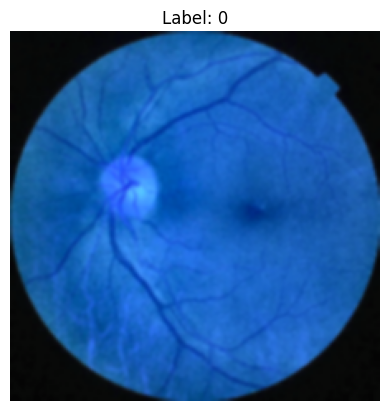

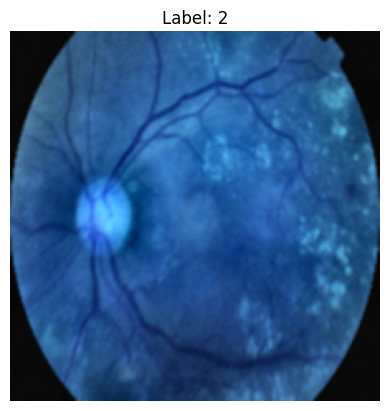

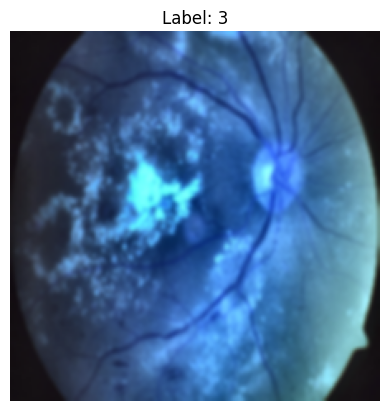

In [13]:
for i in range(3):
    img, label = train_dataset[i]
    plt.imshow(img.permute(1, 2, 0))
    plt.title(f"Label: {label}")
    plt.axis("off")
    plt.show()

# Model Definition

In [14]:
import torch.nn as nn
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights

class MobileNetDR(nn.Module):
    def __init__(self, num_classes=5):
        super(MobileNetDR, self).__init__()
        
        # Load MobileNetV3 with latest ImageNet weights
        weights = MobileNet_V3_Small_Weights.DEFAULT
        self.model = mobilenet_v3_small(weights=weights)

        # Replace the final classifier layer
        in_features = self.model.classifier[3].in_features
        self.model.classifier[3] = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)

In [15]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

model = MobileNetDR(num_classes=5).to(device)
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 97.0MB/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


### Trainig Loop

In [17]:
print("Unique labels in y:", np.unique(y))

Unique labels in y: [0 1 2 3 4]


In [18]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return (preds == labels).float().mean()

In [19]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, cohen_kappa_score

In [20]:
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    running_acc = 0.0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Metrics
        running_loss += loss.item() * images.size(0)
        running_acc += accuracy(outputs, labels) * images.size(0)

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = running_acc / len(loader.dataset)

    return epoch_loss, epoch_acc

def validate(model, loader, criterion, save_best=True, best_f1=0.0, model_path="mobilenet_dr_weights.pth"):
    model.eval()
    running_loss = 0.0
    running_acc = 0.0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            running_acc += accuracy(outputs, labels) * images.size(0)

            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = running_acc / len(loader.dataset)

    # Compute additional metrics
    f1 = f1_score(all_labels, all_preds, average='macro')
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    kappa = cohen_kappa_score(all_labels, all_preds)
    conf_matrix = confusion_matrix(all_labels, all_preds)

    # Save best model
    if save_best and f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), model_path)

    return {
        "loss": epoch_loss,
        "acc": epoch_acc,
        "f1": f1,
        "precision": precision,
        "recall": recall,
        "kappa": kappa,
        "conf_matrix": conf_matrix,
        "best_f1": best_f1
    }

In [21]:
best_f1 = 0.0
EPOCHS = 25

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
    val_metrics = validate(model, val_loader, criterion, best_f1=best_f1)

    best_f1 = val_metrics["best_f1"]  # update best F1 if improved

    # Update learning rate based on val F1
    scheduler.step(val_metrics["f1"])

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val   Loss: {val_metrics['loss']:.4f} | Val Acc: {val_metrics['acc']:.4f}")
    print(f"  F1: {val_metrics['f1']:.4f} | Precision: {val_metrics['precision']:.4f} | Recall: {val_metrics['recall']:.4f} | Kappa: {val_metrics['kappa']:.4f}")
    print(f"  Confusion Matrix:\n{val_metrics['conf_matrix']}")

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/25
  Train Loss: 1.0294 | Train Acc: 0.6634
  Val   Loss: 1.6566 | Val Acc: 0.5130
  F1: 0.1701 | Precision: 0.2994 | Recall: 0.2191 | Kappa: 0.0587
  Confusion Matrix:
[[361   0   0   0   0]
 [ 73   0   1   0   0]
 [185   0  14   1   0]
 [ 28   0  10   1   0]
 [ 55   0   4   0   0]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2/25
  Train Loss: 0.7443 | Train Acc: 0.8470
  Val   Loss: 1.3256 | Val Acc: 0.6289
  F1: 0.2914 | Precision: 0.4247 | Recall: 0.3117 | Kappa: 0.3384
  Confusion Matrix:
[[360   0   1   0   0]
 [ 64   0  10   0   0]
 [101   0  97   1   1]
 [  8   0  26   1   4]
 [ 31   0  25   0   3]]
Epoch 3/25
  Train Loss: 0.6079 | Train Acc: 0.9105
  Val   Loss: 1.0172 | Val Acc: 0.7271
  F1: 0.4467 | Precision: 0.5254 | Recall: 0.4415 | Kappa: 0.5506
  Confusion Matrix:
[[358   0   3   0   0]
 [ 50   2  22   0   0]
 [ 31   6 151   7   5]
 [  2   0  22   7   8]
 [  8   2  32   2  15]]
Epoch 4/25
  Train Loss: 0.5516 | Train Acc: 0.9403
  Val   Loss: 1.1468 | Val Acc: 0.6944
  F1: 0.4999 | Precision: 0.6188 | Recall: 0.4902 | Kappa: 0.5198
  Confusion Matrix:
[[353   8   0   0   0]
 [ 24  43   6   0   1]
 [ 45  61  90   3   1]
 [  4   1  22   6   6]
 [  9  15  17   1  17]]
Epoch 5/25
  Train Loss: 0.5184 | Train Acc: 0.9546
  Val   Loss: 0.9885 | Val Acc: 0.7667
  F1: 0.5252 | Precision: 0.64

In [22]:
!pip install -q torchcam

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.6 MB/s eta 0:00:00


In [23]:
print("Available layer names:")
for name, module in model.named_modules():
    print(f"{name}: {type(module).__name__}")

Available layer names:
: MobileNetDR
model: MobileNetV3
model.features: Sequential
model.features.0: Conv2dNormActivation
model.features.0.0: Conv2d
model.features.0.1: BatchNorm2d
model.features.0.2: Hardswish
model.features.1: InvertedResidual
model.features.1.block: Sequential
model.features.1.block.0: Conv2dNormActivation
model.features.1.block.0.0: Conv2d
model.features.1.block.0.1: BatchNorm2d
model.features.1.block.0.2: ReLU
model.features.1.block.1: SqueezeExcitation
model.features.1.block.1.avgpool: AdaptiveAvgPool2d
model.features.1.block.1.fc1: Conv2d
model.features.1.block.1.fc2: Conv2d
model.features.1.block.1.activation: ReLU
model.features.1.block.1.scale_activation: Hardsigmoid
model.features.1.block.2: Conv2dNormActivation
model.features.1.block.2.0: Conv2d
model.features.1.block.2.1: BatchNorm2d
model.features.2: InvertedResidual
model.features.2.block: Sequential
model.features.2.block.0: Conv2dNormActivation
model.features.2.block.0.0: Conv2d
model.features.2.block.

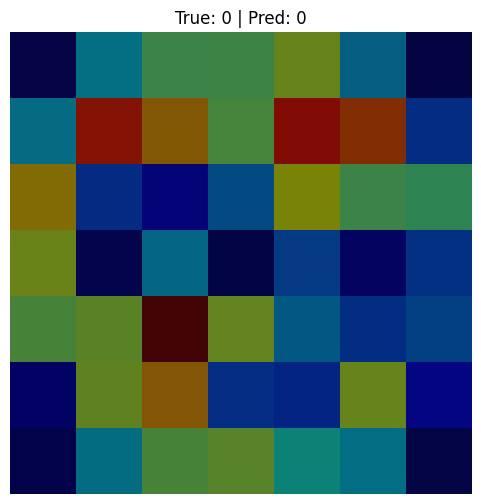

In [24]:
from torchcam.methods import GradCAM
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt

# Target the last convolutional layer before avgpool
cam_extractor = GradCAM(model, target_layer='model.features.12.0')

# Alternative layers you can try for different visualizations:
# cam_extractor = GradCAM(model, target_layer='model.features.11.block.3.0')  # Previous conv layer
# cam_extractor = GradCAM(model, target_layer='model.features.11.block.0.0')  # Earlier in block 11

model.eval()

# Get one sample from val_loader
images, labels = next(iter(val_loader))
image = images[0].unsqueeze(0).to(device)
label = labels[0].item()

# Forward pass
out = model(image)
pred_class = out.argmax().item()

# Generate CAM
activation_map = cam_extractor(pred_class, out)

heatmap = activation_map[0].squeeze().cpu().detach()

plt.figure(figsize=(6, 6))
plt.imshow(to_pil_image(image.squeeze().cpu()))
plt.imshow(heatmap, cmap='jet', alpha=0.5)
plt.title(f"True: {label} | Pred: {pred_class}")
plt.axis('off')
plt.show()